# Automatic ARIMA


Data source: [Avocado sales](https://www.kaggle.com/datasets/navleenbhatia/avocado-dataset) from Kaggle

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import pandas as pd
import numpy as np

In [3]:
# !pip install pmdarima

#### If you use Google Colab, run the following

In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# path = '/content/gdrive/My Drive/data/time_series'
# data = pd.read_csv(path + '/avocado_monthly.csv', index_col='Date')
# data.tail()

In [9]:
path = '/Users/chriskuo/Downloads/data'
data = pd.read_csv(path + '/avocado_monthly.csv', index_col='Date')
data.sort_values(by='Total Volume', ascending=False)
data.tail()

,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
Date,,,,,,,,,,,,,
04-02-2018,7,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
28-01-2018,8,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
21-01-2018,9,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
14-01-2018,10,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico
07-01-2018,11,1.62,17489.58,2894.77,2356.13,224.53,12014.15,11988.14,26.01,0.0,organic,2018,WestTexNewMexico


In [10]:
df = data[(data['type']=='organic') & (data['region']=='TotalUS')].copy()
df = df['Total Volume']
df.columns = ['y']
df = df[pd.to_datetime(df.index)<=pd.to_datetime('2018-02-01')]
#df = df.sort_values(by=df.index)
df.index.max()

/var/folders/b8/hq7p21n142n321y966q8j1600000gn/T/ipykernel_1336/478450109.py:4: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = df[pd.to_datetime(df.index)<=pd.to_datetime('2018-02-01')]


'31-12-2017'

In [11]:
df.index

Index(['27-12-2015', '20-12-2015', '13-12-2015', '06-12-2015', '29-11-2015',
       '22-11-2015', '15-11-2015', '08-11-2015', '01-11-2015', '25-10-2015',
       ...
       '05-02-2017', '29-01-2017', '22-01-2017', '15-01-2017', '08-01-2017',
       '01-01-2017', '28-01-2018', '21-01-2018', '14-01-2018', '07-01-2018'],
      dtype='object', name='Date', length=161)

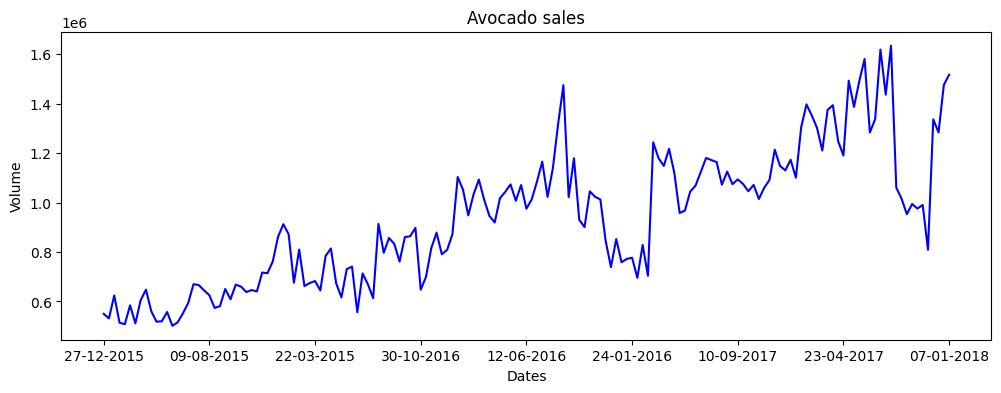

In [12]:
fig, ax = plt.subplots(figsize=(12,4))

# Actual vs. Predicted
ax.plot(df, color='blue')
ax.set_title('Avocado sales')
ax.set_xlabel('Dates')
ax.set_ylabel('Volume')
ax.xaxis.set_major_locator(MultipleLocator(20))
plt.show()

## Train-test-split

In [13]:
train_len = int(df.shape[0] * 0.8)
test_len = df.shape[0] - train_len
train, test = df[:train_len], df[train_len:]
print(f"{train_len} train samples")
print(f"{test_len} test samples")

128 train samples
33 test samples


## Differencing

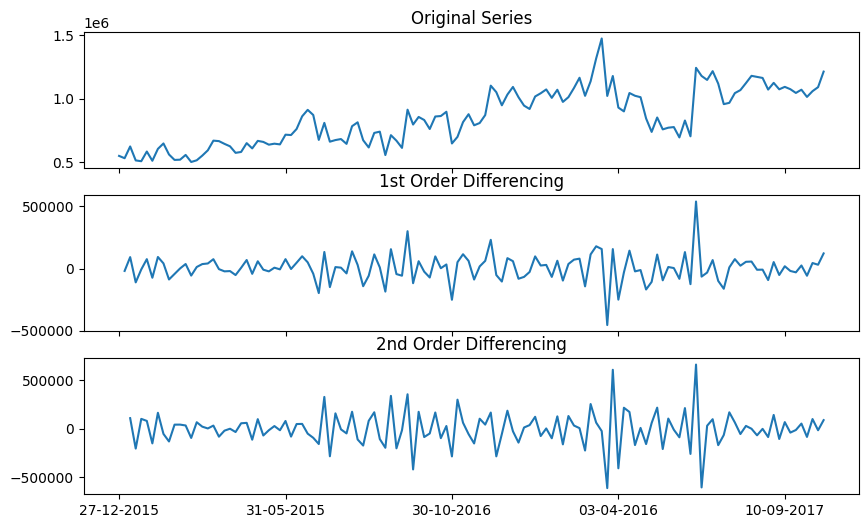

In [14]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':100})
lag_len = 15
fig, axes = plt.subplots(3, 1, sharex=True)

# Original Series
axes[0].plot(train.values); axes[0].set_title('Original Series')

# 1st Differencing
axes[1].plot(train.diff()); axes[1].set_title('1st Order Differencing')


# 2nd Differencing
axes[2].plot(train.diff().diff()); axes[2].set_title('2nd Order Differencing')

axes[0].xaxis.set_major_locator(MultipleLocator(30))

plt.show()

In [15]:
print(adfuller(df.diff().dropna()))

(-6.220532951395323, 5.236718691178238e-08, 8, 151, {'1%': -3.4744158894942156, '5%': -2.880878382771059, '10%': -2.577081275821236}, 3824.7805680271067)


#### Interpretation for the Dickey-Fuller test
In statistics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample.

Null hypothesis: Not stationary
Alternative hypothesis: stationary

- 1st position -6.305260422541897 is the critical value.
- 2nd position 3.335628971310153e-08 is the p-value. It is far less than the critical value 5% significance level. The null hypothesis can be rejected. The time series after differencing is stationary.
- 3rd position 8 is the number of lagged used.
- 4th position 150 is the number of observations used.
- 5th position has the t-stat values.
    {'1%': -3.474714913481481,
    '5%': -2.881008708148148,
    '10%': -2.5771508444444446},
    3798.4017312693773)

## ACF

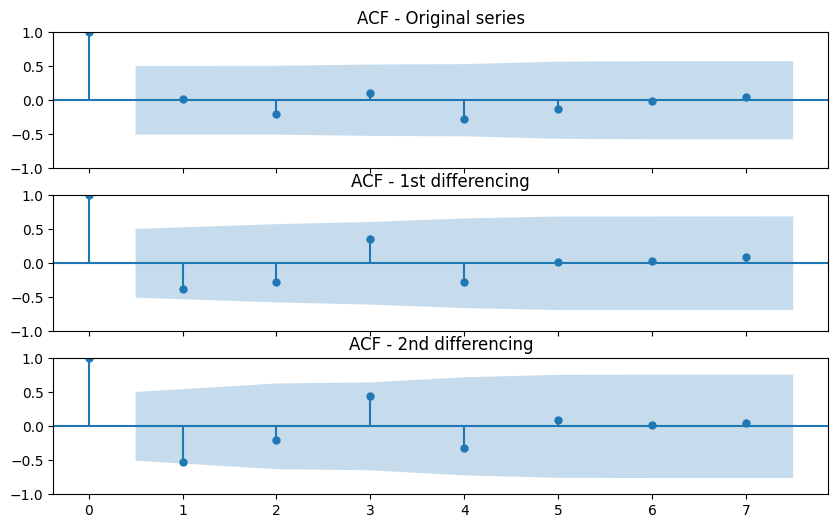

In [16]:
from statsmodels.graphics.tsaplots import plot_acf
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':100})
lag_len = 15
fig, axes = plt.subplots(3, 1, sharex=True)

# Original Series
plot_acf(train.values[0:lag_len], ax=axes[0], title = 'ACF - Original series')

# 1st Differencing
plot_acf(train.diff().dropna()[0:lag_len], ax=axes[1], title = 'ACF - 1st differencing')

# 2nd Differencing
plot_acf(train.diff().diff().dropna()[0:lag_len], ax=axes[2], title = 'ACF - 2nd differencing')

plt.show()

## PACF

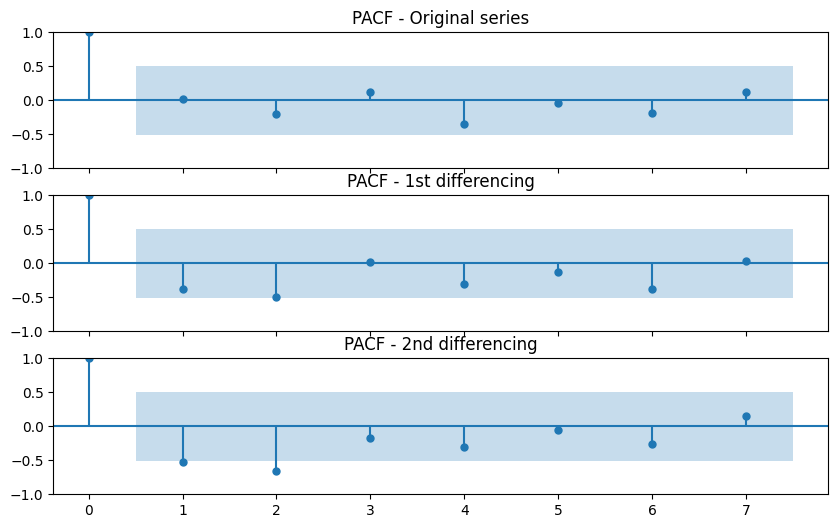

In [17]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':100})
lag_len = 15
fig, axes = plt.subplots(3, 1, sharex=True)

# Original Series
plot_pacf(train.values[0:lag_len], ax=axes[0], title = 'PACF - Original series')

# 1st Differencing
plot_pacf(train.diff().dropna()[0:lag_len], ax=axes[1], title = 'PACF - 1st differencing')

# 2nd Differencing
plot_pacf(train.diff().diff().dropna()[0:lag_len], ax=axes[2], title = 'PACF - 2nd differencing')

plt.show()

## ARIMA

In [19]:
import pmdarima as pm
model = pm.auto_arima(train,
                      d=None,
                      seasonal=False,
                      stepwise=True,
                      suppress_warnings=True,
                      error_action="ignore",
                      max_p=None,
                      max_order=None,
                      trace=True)

/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finit

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3313.500, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3304.834, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3302.709, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3311.789, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3303.614, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3303.931, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3305.861, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3301.571, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3301.526, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3303.458, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3302.312, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3302.483, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3302.824, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : 

In [20]:
fcast = model.predict(n_periods=test_len, return_conf_int=True, alpha=0.05)
forecasts = fcast[0]
confidence_intervals = fcast[1]

/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


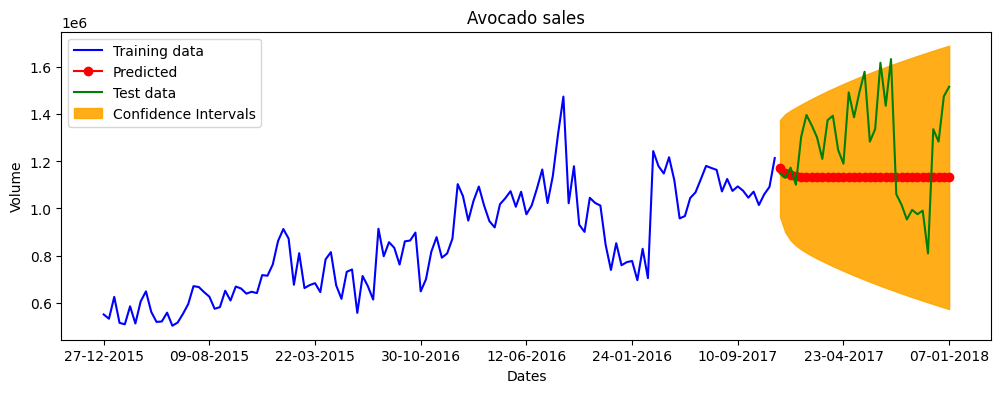

In [21]:
def plot_it():
    fig, ax = plt.subplots(figsize=(12,4))

    # Actual vs. Predicted
    ax.plot(train, color='blue', label='Training data')
    ax.plot(test.index, forecasts, color='red', marker='o',
                label='Predicted')
    ax.plot(test.index, test, color='green', label='Test data')
    ax.set_title('Avocado sales')
    ax.set_xlabel('Dates')
    ax.set_ylabel('Volume')
    conf_int = np.asarray(confidence_intervals)

    # Confidence intervals
    ax.fill_between(test.index,
                        conf_int[:, 0], conf_int[:, 1],
                        alpha=0.9, color='orange',
                        label="Confidence Intervals")
    # Make a plot with major ticks that are multiples of 20
    ax.legend()
    ax.xaxis.set_major_locator(MultipleLocator(20))
    plt.show()

plot_it()

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
print(f"MAPE: {mean_absolute_percentage_error(test, forecasts)}")

MAPE: 0.16041697740382152


### Model can be updated in each iteration

In [23]:
def one_period_forecast():
    fcast = model.predict(n_periods=1, return_conf_int=True, alpha=0.05)
    # fcast is a list of two lists.
    # The first list is the forecast
    forecasts = fcast[0].tolist()
    # The second list is the confidence interval
    confidence_intervals = fcast[1]
    return ( forecasts,
             np.asarray(confidence_intervals).tolist()[0])

forecasts = []
confidence_intervals = []

for add_obs in test:
    fc, conf = one_period_forecast()
    forecasts.append(fc)
    confidence_intervals.append(conf)
    # Updates the existing model
    model.update(add_obs)

/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs

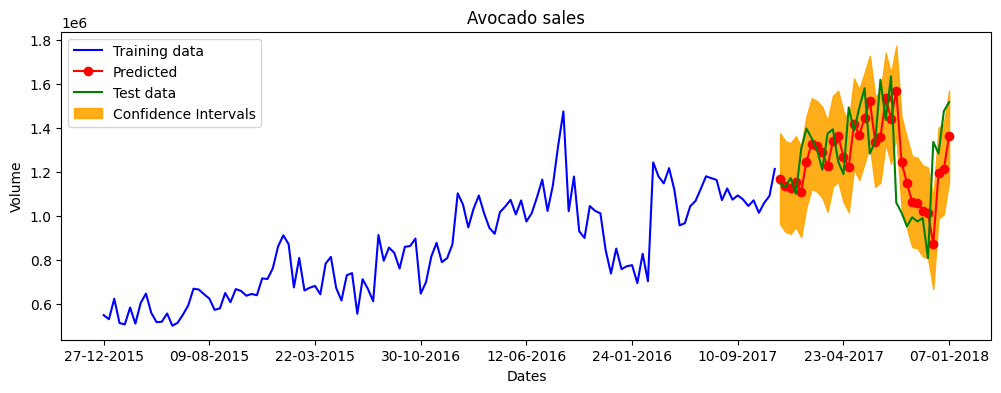

In [24]:
plot_it()

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
print(f"MAPE: {mean_absolute_percentage_error(test, forecasts)}")

MAPE: 0.1129141777034008


## SARIMA

In [26]:
import pmdarima as pm
model = pm.auto_arima(train,
                      seasonal=True,
                      start_P=1,
                      start_q=1,
                      max_p=None,
                      max_q=None,
                      m=12,
                      d=1,
                      D=1,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
model.summary()

/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=3037.272, Time=0.23 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3073.194, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3044.440, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3033.862, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3068.021, Time=0.01 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=3035.598, Time=0.09 sec


/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finit

 ARIMA(0,1,1)(0,1,2)[12]             : AIC=3035.645, Time=0.22 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3043.593, Time=0.05 sec


/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=3041.087, Time=0.02 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=3034.493, Time=0.08 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=3036.266, Time=0.05 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=3035.095, Time=0.04 sec


/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finit

 ARIMA(1,1,2)(0,1,1)[12]             : AIC=3036.837, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=3035.874, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit time: 1.492 seconds


/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  128
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1513.931
Date:                            Sun, 08 Jun 2025   AIC                           3033.862
Time:                                    20:19:40   BIC                           3042.096
Sample:                                         0   HQIC                          3037.204
                                            - 128                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3298      0.122     -2.694      0.007      -0.570      -0.090
ma.S.L12      -0.7296      0.127     -5.739      0.000      -0.979      -0.480
sigma2        2.2e+10   2.61e-12   8.43e+21      0.000     2.2e+10     2.2e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                50.45
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                             0.13
Prob(H) (two-sided):                  0.05   Kurtosis:                         6.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.94e+37. Standard errors may be unstable.
"""

In [27]:
forecasts = []
confidence_intervals = []

for add_obs in test:
    fc, conf = one_period_forecast()
    forecasts.append(fc)
    confidence_intervals.append(conf)
    # Updates the existing model
    model.update(add_obs)

/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs

In [28]:
print(f"MAPE: {mean_absolute_percentage_error(test, forecasts)}")

MAPE: 0.11871748249243473


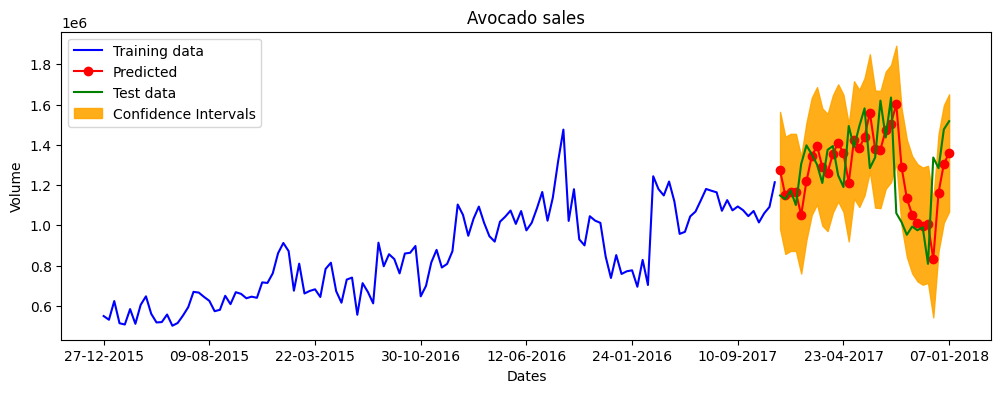

In [29]:
plot_it()